# EDA

In [1]:
import boto3
import io
import json
import pandas as pd
import numpy as np
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns; #sns.set(style="ticks", color_codes=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

s3_resource = boto3.resource(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

In [3]:
# getting preprocessed data
df_full = []
prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix="processed")
keys = [obj.key for obj in prefix_objs]
for key in keys[1:]:
    obj = s3_client.get_object(Bucket="cge", Key=key)
    df = pd.read_csv(io.BytesIO(obj["Body"].read()))
    
    try:
        df_grouped = df[[
            "station_name",
            "precipitation_lag_1H",
            "temperature_lag_1H",
            "relative_humidity_lag_1H",
            "pressure_lag_1H",
            "wind_velocity_x_lag_1H",
            "wind_velocity_y_lag_1H",
            "wind_blow_x_lag_1H",
            "wind_blow_y_lag_1H"
        ]].groupby("station_name", as_index=False).mean()
    except:
        df_grouped = df[[
            "station_name",
            "precipitation_lag_1H",
            "temperature_lag_1H",
            "relative_humidity_lag_1H",
            "pressure_lag_1H"
        ]].groupby("station_name", as_index=False).mean()

    df_full.append(df_grouped)

In [82]:
df_grouped = pd.concat(df_full)
df_grouped

,station_name,precipitation_lag_1H,temperature_lag_1H,relative_humidity_lag_1H,pressure_lag_1H,wind_velocity_x_lag_1H,wind_velocity_y_lag_1H,wind_blow_x_lag_1H,wind_blow_y_lag_1H
0,Anhembi,1.949440,20.797645,75.457379,931.357506,-0.105968,0.425907,-0.383783,0.768364
0,Butantã,2.111367,20.472108,80.141187,933.056320,0.020492,0.003795,0.030196,0.037305
0,Campo Limpo,1.720926,20.828033,78.628181,931.790821,-0.232322,0.208733,-0.553067,0.600468
0,Capela do Socorro,1.852940,18.980764,89.168866,934.898782,NaN,NaN,NaN,NaN
0,Cidade Ademar,1.750235,20.697501,76.300718,930.913943,0.188826,-0.395791,0.395806,-0.725255
0,Freguesia do Ó,2.096589,20.664419,79.019213,927.133996,-0.205141,0.026434,-0.821665,0.060147
0,Ipiranga,1.863409,20.252540,80.739473,930.195112,NaN,NaN,NaN,NaN
0,Itaim Paulista,1.808878,20.345276,80.682610,935.080348,0.087375,0.042654,0.476692,0.258647
0,Itaquera,1.836740,20.008110,80.861833,933.177913,NaN,NaN,NaN,NaN
0,Jabaquara,2.051002,19.245555,73.049629,930.647960,NaN,NaN,NaN,NaN


In [83]:
df_grouped = df_grouped[df_grouped["station_name"].str.contains("Parelheiros") == False]
df_grouped = df_grouped.set_index("station_name")

In [84]:
df_grouped.columns = [i.split("_lag_1H")[0] for i in list(df_grouped.columns)]
df_grouped

,precipitation,temperature,relative_humidity,pressure,wind_velocity_x,wind_velocity_y,wind_blow_x,wind_blow_y
station_name,,,,,,,,
Anhembi,1.949440,20.797645,75.457379,931.357506,-0.105968,0.425907,-0.383783,0.768364
Butantã,2.111367,20.472108,80.141187,933.056320,0.020492,0.003795,0.030196,0.037305
Campo Limpo,1.720926,20.828033,78.628181,931.790821,-0.232322,0.208733,-0.553067,0.600468
Capela do Socorro,1.852940,18.980764,89.168866,934.898782,NaN,NaN,NaN,NaN
Cidade Ademar,1.750235,20.697501,76.300718,930.913943,0.188826,-0.395791,0.395806,-0.725255
Freguesia do Ó,2.096589,20.664419,79.019213,927.133996,-0.205141,0.026434,-0.821665,0.060147
Ipiranga,1.863409,20.252540,80.739473,930.195112,NaN,NaN,NaN,NaN
Itaim Paulista,1.808878,20.345276,80.682610,935.080348,0.087375,0.042654,0.476692,0.258647
Itaquera,1.836740,20.008110,80.861833,933.177913,NaN,NaN,NaN,NaN


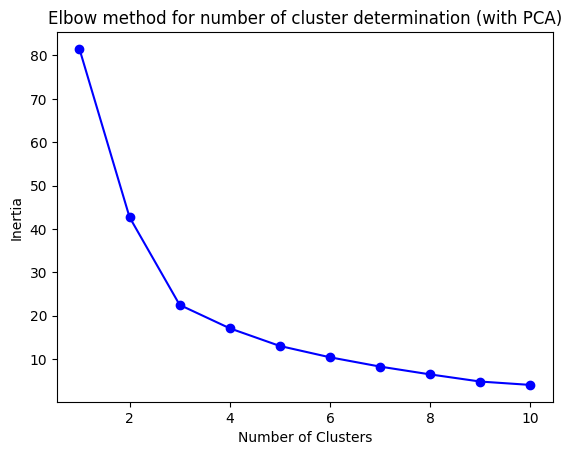

In [85]:
# Preparar os dados
X = df_grouped[["precipitation", "temperature", "relative_humidity"]].iloc[:, :].values  # Selecionar todas as colunas do conjunto de dados

# Normalizar os dados
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Encontrar o número ideal de clusters utilizando o método Elbow
n_clusters = range(1, 11)
inertias = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plotar o gráfico do método Elbow
plt.plot(n_clusters, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow method for number of cluster determination (with PCA)')
plt.show()

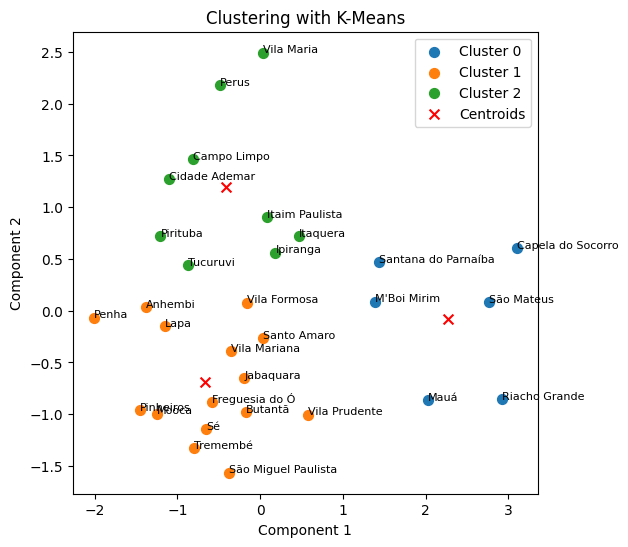

In [86]:
# Clusterizar os dados com o número de clusters escolhido
k = 3  # Número de clusters escolhido
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_pca)

kmeans_output = pd.DataFrame(
    data=X_pca,
    index=df_grouped.index
    )

kmeans_output["cluster"] = y_kmeans

# Plotar os clusters encontrados
plt.subplots(figsize=(6, 6))
plt.scatter(kmeans_output[kmeans_output.cluster == 0][0], kmeans_output[kmeans_output.cluster == 0][1], s=50, label='Cluster 0')
plt.scatter(kmeans_output[kmeans_output.cluster == 1][0], kmeans_output[kmeans_output.cluster == 1][1], s=50, label='Cluster 1')
plt.scatter(kmeans_output[kmeans_output.cluster == 2][0], kmeans_output[kmeans_output.cluster == 2][1], s=50, label='Cluster 2')
# plt.scatter(X_pca[y_kmeans == 3, 0], X_pca[y_kmeans == 3, 1], s=100, c='purple', label='Cluster 4')

for idx, row in kmeans_output.iterrows(): 
    plt.text(row[0], row[1], idx, size=8)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red', label='Centroids', marker="x")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clustering with K-Means')
plt.legend(prop={'size': 10})

In [87]:
df_grouped = df_grouped.merge(kmeans_output, left_index=True, right_index=True)
df_grouped = df_grouped.drop([0, 1], axis=1)
df_grouped = df_grouped.sort_values("cluster")
df_grouped = df_grouped[["precipitation", "temperature", "relative_humidity", "cluster"]]
df_grouped

,precipitation,temperature,relative_humidity,cluster
station_name,,,,
Capela do Socorro,1.852940,18.980764,89.168866,0
São Mateus,1.936568,19.041406,87.750561,0
Santana do Parnaíba,1.876959,19.681583,84.209751,0
Riacho Grande,2.084430,18.636648,86.317461,0
M'Boi Mirim,1.939557,19.910831,85.296972,0
Mauá,2.087845,19.087075,84.058023,0
Anhembi,1.949440,20.797645,75.457379,1
Vila Formosa,1.940529,20.281289,79.050065,1
Tremembé,2.170077,21.075564,80.221718,1


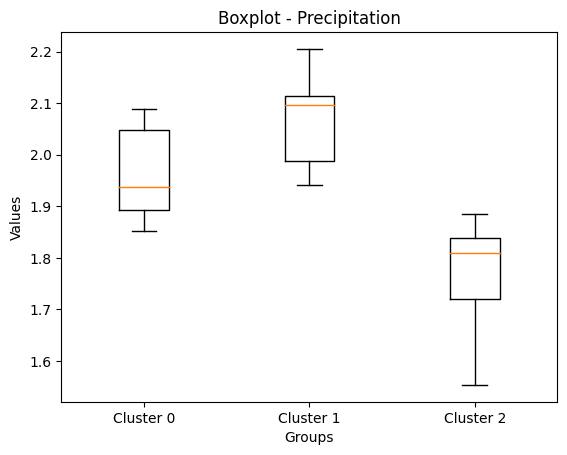

Cluster 0
count    6.000000
25%      1.891862
50%      1.938062
75%      2.048212
Name: Precipitation, dtype: float64

Cluster 1
count    15.000000
25%       1.987883
50%       2.096589
75%       2.114697
Name: Precipitation, dtype: float64

Cluster 2
count    9.000000
25%      1.720926
50%      1.808878
75%      1.839052
Name: Precipitation, dtype: float64



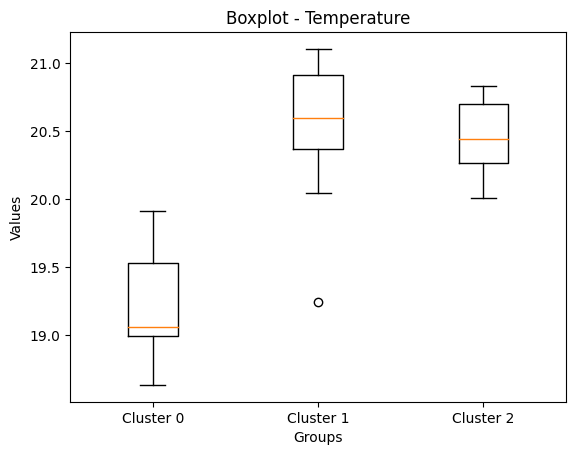

Cluster 0
count     6.000000
25%      18.995925
50%      19.064240
75%      19.532956
Name: Temperature, dtype: float64

Cluster 1
count    15.000000
25%      20.367715
50%      20.597915
75%      20.914590
Name: Temperature, dtype: float64

Cluster 2
count     9.000000
25%      20.265092
50%      20.445873
75%      20.697501
Name: Temperature, dtype: float64



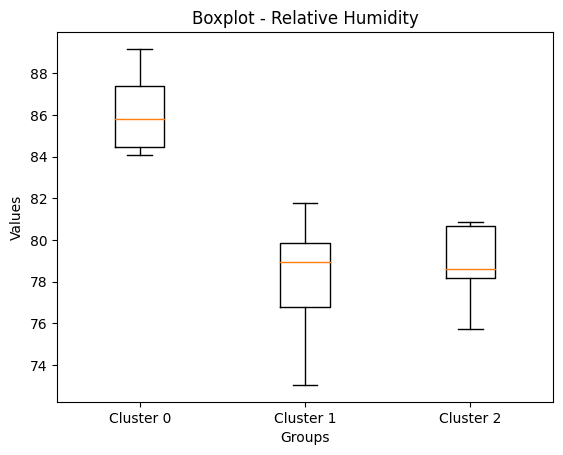

Cluster 0
count     6.000000
25%      84.481556
50%      85.807216
75%      87.392286
Name: Relative Humidity, dtype: float64

Cluster 1
count    15.000000
25%      76.793477
50%      78.960876
75%      79.858936
Name: Relative Humidity, dtype: float64

Cluster 2
count     9.000000
25%      78.184523
50%      78.628181
75%      80.682610
Name: Relative Humidity, dtype: float64



In [88]:
df_grouped.columns = [
    "Precipitation", 
    "Temperature", 
    "Relative Humidity",
    "cluster"
    ]

vars = list(df_grouped.drop("cluster", axis=1).columns)

for i in vars:
    # Lista com os grupos de dados
    
    dados = [
        df_grouped[df_grouped.cluster == 0][i], 
        df_grouped[df_grouped.cluster == 1][i], 
        df_grouped[df_grouped.cluster == 2][i],
        # df_grouped[df_grouped.cluster == 3][i]
        ]

    # Nomes dos grupos
    nomes_grupos = [
        'Cluster 0', 
        'Cluster 1', 
        'Cluster 2', 
        # "Cluster 3"
        ]

    # Criar o boxplot
    plt.boxplot(dados, labels=nomes_grupos)

    # Adicionar título e rótulos dos eixos
    plt.title(f'Boxplot - {i}')
    plt.xlabel('Groups')
    plt.ylabel('Values')

    # Exibir o boxplot
    plt.show()

    print("Cluster 0")
    print(dados[0].describe().loc[['count', '25%', "50%", "75%"]])
    print("")

    print("Cluster 1")
    print(dados[1].describe().loc[['count', '25%', "50%", "75%"]])
    print("")

    print("Cluster 2")
    print(dados[2].describe().loc[['count', '25%', "50%", "75%"]])
    print("")